# ANSWERS FOR QUESTIONS 6, 9 AND 10

In [2]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from lets_plot import *
import matplotlib as plt
import networkx as nx
LetsPlot.setup_html()# necessary to show plots on jupyter notebook

## QUESTION 6

Creating causal graph:

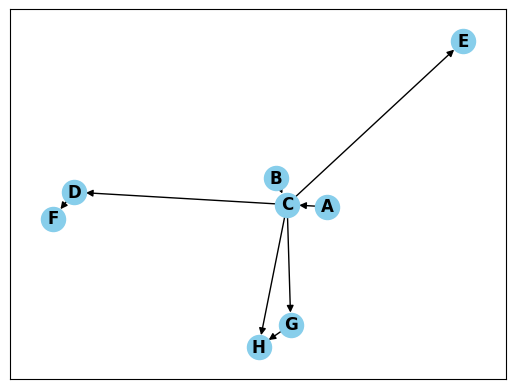

In [3]:
# creating DAG
causal_graph = nx.DiGraph()

# Adding nodes
causal_graph.add_nodes_from(["A", "B", "C", "D", "E", "F", "G", "H"])

# Adding edges
causal_graph.add_edges_from([("A", "C"), ("B", "C"), ("C", "E"), ("C", "G"),
                             ("C", "D"), ("C", "H"), ("D", "F"), ("G", "H")])

nx.draw_networkx(causal_graph, with_labels=True, node_size=300, node_color="skyblue", font_size=12, font_weight="bold", arrows=True)

a)A y B están correlacionados?

In [4]:
print(not(nx.d_separated(causal_graph, {"A"}, {"B"},{})))

False


b)Qué ocurre entre A y B si condiciono en C?
Si que hay correlación al condicionar C.

In [5]:
print(not(nx.d_separated(causal_graph, {"A"}, {"B"},{"C"})))

True


c)A y G están correlacionados?

In [6]:
print(not(nx.d_separated(causal_graph, {"A"}, {"G"},{})))

True


e)E y D están correlacionados?

In [7]:
print(not(nx.d_separated(causal_graph, {"E"}, {"D"},{})))

True


g)Qué ocurre entre E y D si condiciono en C?
Al condicionar C ya no estan correlacionados.

In [8]:
print(not(nx.d_separated(causal_graph, {"E"}, {"D"},{"C"})))

False


h)C y F están correlacionados?

In [9]:
print(not(nx.d_separated(causal_graph, {"E"}, {"D"},{})))

True


j)Que ocurre entre C y F si condiciono en D?

In [10]:
print(not(nx.d_separated(causal_graph, {"C"}, {"F"},{"D"})))

False


k)F y H están correlacionados?

In [11]:
print(not(nx.d_separated(causal_graph, {"F"}, {"H"},{})))

True


i)Qué ocurre entre H y F si condiciono en C?
Si se condiciona C, H y F ya no estan correlacionados.

In [12]:
print(not(nx.d_separated(causal_graph, {"F"}, {"H"},{"C"})))

False


m)Qué ocurre entre H y F si condiciono en G?
Seguiran conectados.

In [13]:
print(not(nx.d_separated(causal_graph, {"F"}, {"H"},{"G"})))

True


n)Qué ocurre entre C y H si condiciono en F?
No ocurre nada, mantienen su asociación causal directa.

In [14]:
print(not(nx.d_separated(causal_graph, {"C"}, {"H"},{"F"})))

True


o)Qué ocurre entre C y H si condiciono en B?
No ocurre nada, mantienen su asociación causal directa.

In [15]:
print(not(nx.d_separated(causal_graph, {"C"}, {"H"},{"B"})))

True


p)Supongamos que queremos medir el efecto causal de C en H. Hay que tener en cuenta G para algo?
Si ya que como se ve en el gráfico, y como confirma networkx, hay correlación directa entre G y H. Se debe condicionar G para poder medir el efecto de C en H.

In [16]:
print(not(nx.d_separated(causal_graph, {"G"}, {"H"},{})))

True


## QUESTION 9
Question 9 ask for the ATE of sales in weekly_amount_sold.
The first step is loading the dataset.

In [17]:
df_xmas=pd.read_csv("xmas_sales.csv")

Now, the best option for conditioning on avg_week_sales is to add it to the model. The primary reason for calculating the Average Treatment Effect (ATE) with linear regression is that avg_week_sales is continuous, making it easier than creating groups for each value. Additionally, weeks_to_xmas is included because it has a causal effect on weekly_amount_sold. It is evident that adding weeks_to_xmas helps reduce the standard error of is_on_sale.

ATE=52.098

In [54]:
# regression model with xmas
regression_model_xmas = smf.ols('weekly_amount_sold ~ C(is_on_sale)+avg_week_sales+C(weeks_to_xmas)', data=df_xmas).fit()
print(regression_model_xmas.summary().tables[1])

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -54.4981      5.158    -10.566      0.000     -64.614     -44.382
C(is_on_sale)[T.1]       52.0981      2.285     22.803      0.000      47.618      56.579
C(weeks_to_xmas)[T.1]    33.9861      3.020     11.255      0.000      28.064      39.908
C(weeks_to_xmas)[T.2]    70.8106      3.051     23.212      0.000      64.828      76.793
C(weeks_to_xmas)[T.3]   111.8251      3.061     36.535      0.000     105.822     117.828
avg_week_sales            3.7924      0.242     15.662      0.000       3.318       4.267


In [19]:
# regression model without xmas
regression_model_xmas = smf.ols('weekly_amount_sold ~ C(is_on_sale)+avg_week_sales', data=df_xmas).fit()
print(regression_model_xmas.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.1542      6.306      0.342      0.733     -10.213      14.521
C(is_on_sale)[T.1]    68.8460      2.949     23.346      0.000      63.063      74.629
avg_week_sales         3.2447      0.318     10.194      0.000       2.620       3.869


El siguiente codigo calcula el ATE condicionando avg_week_sales y weeks_to_xmas pero de manera "manual", sin regresión lineal.

In [131]:
def ate_by_var(var):
    # Calcular el promedio de weekly_amount_sold para los diferentes grupos de los tratados
    treated_mean = df_xmas[df_xmas['is_on_sale'] == 1].groupby(var)['weekly_amount_sold'].mean()

    # Calcular el promedio de weekly_amount_sold para los diferentes grupos de los no tratados
    untreated_mean = df_xmas[df_xmas['is_on_sale'] == 0].groupby(var)['weekly_amount_sold'].mean()

    # Calcular la diferencia entre los promedios
    difference = treated_mean - untreated_mean

    # Calculo de la probabilidad de cada grupo
    prob = df_xmas.groupby(var).size()/df_xmas.shape[0]

    # Calcular el ATE usando la fórmula de ajuste
    ate = (difference * prob).sum()

    # Imprimir el resultado
    print("Average Treatment Effect (ATE):", ate)
    return ate

aux=ate_by_var(["weeks_to_xmas", "avg_week_sales"])

Average Treatment Effect (ATE): 6.966304166666667


La misma función de antes pero modificada para calcular el ATE individual de cada variable y realizando un sumatorio al final.

In [132]:
def ate_by_var(vars):
    ate=0
    for var in vars:
        # Calcular el promedio de weekly_amount_sold para los diferentes grupos de los tratados
        treated_mean = df_xmas[df_xmas['is_on_sale'] == 1].groupby(var)['weekly_amount_sold'].mean()

        # Calcular el promedio de weekly_amount_sold para los diferentes grupos de los no tratados
        untreated_mean = df_xmas[df_xmas['is_on_sale'] == 0].groupby(var)['weekly_amount_sold'].mean()

        # Calcular la diferencia entre los promedios
        difference = treated_mean - untreated_mean

        # Calculo de la probabilidad de cada grupo
        prob = df_xmas.groupby(var).size()/df_xmas.shape[0]

        # Calcular el ATE usando la fórmula de ajuste
        ate += (difference * prob).sum()


    # Imprimir el resultado
    print("Average Treatment Effect (ATE):", ate)
    return ate

aux=ate_by_var(["weeks_to_xmas", "avg_week_sales"])

Average Treatment Effect (ATE): 118.90892247664985


# QUESTION 10
It is necessary to calculate the ATE, but now for the cross-email case.

In [54]:
df_cross_email=pd.read_csv("cross_sell_email.csv")
print(df_cross_email.isnull().sum())
df_cross_email.head()

gender              0
cross_sell_email    0
age                 0
conversion          0
dtype: int64


,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0


In [55]:
print(df_cross_email.dtypes)

gender               int64
cross_sell_email    object
age                  int64
conversion           int64
dtype: object


Encoding cross_sell_email because it is categorical and to use sm.Logit it should be numerical.Also, it is created one dataframe with objetive variable and other with independent variables to predict.

In [56]:
df_Y=df_cross_email['conversion']
df_cross_email_encoded = pd.get_dummies(df_cross_email, columns=['cross_sell_email'],dtype=int)
#df_cross_email_encoded = pd.concat([df_cross_email, df_cross_email_encoded], axis=1)
df_X=df_cross_email_encoded.drop(columns=['conversion', 'age', 'gender'])
print(df_X.dtypes)
df_X.head()

cross_sell_email_long        int64
cross_sell_email_no_email    int64
cross_sell_email_short       int64
dtype: object


,cross_sell_email_long,cross_sell_email_no_email,cross_sell_email_short
0,0,0,1
1,0,0,1
2,1,0,0
3,1,0,0
4,0,1,0


In [57]:
regression_model_emails = sm.Logit(df_Y,df_X).fit()
print(regression_model_emails.summary())

Optimization terminated successfully.
         Current function value: 0.263106
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             conversion   No. Observations:                  323
Model:                          Logit   Df Residuals:                      320
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 Apr 2024   Pseudo R-squ.:                 0.03402
Time:                        17:39:02   Log-Likelihood:                -84.983
converged:                       True   LL-Null:                       -87.976
Covariance Type:            nonrobust   LLR p-value:                   0.05016
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
cross_sell_email_long        -2.8430      0.420     -6.769      0.000      -3.

Age and gender do not seem to introduce any bias because there is balance in treatment (cross-sell email) and outcome (conversion).

In [58]:
(ggplot(df_cross_email,aes("gender"))
    + geom_bar(aes(fill="cross_sell_email"))
    + facet_wrap(facets="cross_sell_email", ncol=3)
    + ggtitle("GENDER BY CROSS SELL EMAIL")
    )

In [59]:
(ggplot(df_cross_email,aes("age", color="cross_sell_email"))
    + geom_histogram()
    + facet_wrap(facets="cross_sell_email", ncol=3)
    + ggtitle("AGE BY CROSS SELL EMAIL")
    )

It is remarkable that there is a imbalance between cases with conversions and without conversions in the dataset.

In [60]:
(
    ggplot(df_cross_email, aes("conversion"))
    + geom_bar()
    + ggtitle("CASES WITH CONVERSION AND WITHOUT IN THE DATASET")
)

In [61]:
(ggplot(df_cross_email,aes("gender"))
    + geom_bar(aes(group="conversion"))
    + facet_wrap(facets="conversion", ncol=2)
    + ggtitle("GENDER BY CONVERSION")
    )


In [62]:
(ggplot(df_cross_email,aes("age"))
    + geom_histogram(aes(group="conversion", fill="conversion"))
    + facet_wrap(facets="conversion", ncol=2)
    + ggtitle("AGE BY CONVERSION")
    )